# testing weights calculation
FREDDA is C++ and dumb and I don't want a buggy implementation - so let's find an elegant way of calculating weights.

In [32]:
import numpy as np
from pylab import *
import fdmt
import boxcar
import simfrb
%matplotlib inline

nf = 336 # number of channels - must be a power of 2 currently.
fmax = 1448. +0.5#  Freuency of the top of the band in MHz
df = 1.0 # Channel bandwidth in MHz
fmin = fmax - nf*df # Frequency of the bottom of the band in MHz
nd = 1024 # Number of DM trials to do
nt = 256 # Number of samples per block
tsamp = 1.0 # milliseconds
reload(fdmt)
nbox = 32
thefdmt = fdmt.Fdmt(fmin, df, nf, nd, nt) # make FDMT
for i, s in enumerate(thefdmt.hist_state_shape):
    print 'Iteration', i, 'shape=', s, 'total elements=', s.prod()

Iteration 0 shape= [336   6 262] total elements= 528192
Iteration 1 shape= [168  10 266] total elements= 446880
Iteration 2 shape= [ 84  19 275] total elements= 438900
Iteration 3 shape= [ 42  37 293] total elements= 455322
Iteration 4 shape= [ 21  72 328] total elements= 495936
Iteration 5 shape= [ 11 139 395] total elements= 603955
Iteration 6 shape= [  6 266 522] total elements= 833112
Iteration 7 shape= [  3 490 746] total elements= 1096620
Iteration 8 shape= [   2  847 1103] total elements= 1868482
Iteration 9 shape= [   1 1024 1280] total elements= 1310720


In [33]:
# get effetive sigma - python version of Clancy's code
def get_eff_sigma(thefdmt, idt, width):
    assert width > 0
    assert 0 <= idt < thefdmt.max_dt
    nchan = thefdmt.n_f
    nodes = thefdmt.trace_dm(idt)
    smearing = [n[1]+1 for n in nodes]
    total_var = 0
    for chan in xrange(nchan):
        if smearing[chan] > width:
            H = smearing[chan]
            L = width
        else:
            L = smearing[chan]
            H = width
            
        assert H > 0
        assert L > 0
        
        var_chan = (H-L+1)*(L**2) + (2*L - 1)*L*(L-1)/3
        total_var += var_chan
    
    eff_sigma = pow(float(total_var),0.5)
    
    return eff_sigma

In [34]:
weights1 = np.zeros((nd, nbox))
for idt in xrange(nd):
    for b in xrange(nbox):
        weights1[idt, b] = get_eff_sigma(thefdmt, idt, b+1)

In [35]:
def calc_var(smearing, width):
    if smearing > width:
        H = smearing
        L = width
    else:
        L = smearing
        H = width

    assert H > 0
    assert L > 0

    # Clancy's formula
    var_chan = (H-L+1)*(L**2) + (2*L - 1)*L*(L-1)/3
    
    return var_chan

# Recusrive version
def get_eff_var_recursive(thefdmt, idm, width, ichan=0, iterno=None):
    if iterno is None:
        iterno = len(thefdmt.hist_nf_data) - 1
        # idt it set to -1 when it's a non-power-of-2 FDMT
        assert 0 <= idm < thefdmt.max_dt, 'Invalid Idm ={}'.format(idm)
        assert ichan == 0
        
    nfd = thefdmt.hist_nf_data[iterno]
    nchan = len(nfd)
    chanconfig = nfd[ichan][-1]
    _ , id1, offset, id2, _, _, _ = chanconfig[idm]
    inchan1 = 2*ichan
    inchan2 = 2*ichan+1

    # terminate recursion
    if iterno == 0:
        var_chan1 = calc_var(id1+1, width)
        var_chan2 = calc_var(id2+1, width) 
    else:
        # Cumulative only aplies to the upper channel
        assert inchan2 > inchan1
        var_chan1 = get_eff_var_recursive(thefdmt, id1, width, inchan1, iterno-1)

        # For non power of 2 FDMT, idm ==-1 indicates a copy - so we don't go down the line for this guy.
        if id2 == -1:
            var_chan2 = 0
        else:
            var_chan2 = get_eff_var_recursive(thefdmt, id2, width, inchan2, iterno-1)

    total_var = var_chan1 + var_chan2
    
    return total_var

In [36]:
get_eff_var_recursive(thefdmt, idm=0, width=1)
weights2 = np.zeros((nd, nbox))
for idt in xrange(nd):
    for b in xrange(nbox):
        weights2[idt, b] = np.sqrt(get_eff_var_recursive(thefdmt, idt, b+1))

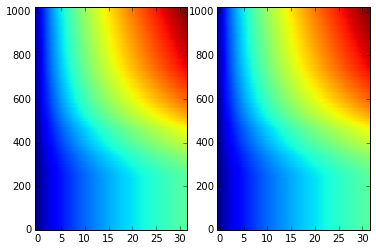

In [37]:
fig, axs = subplots(1,2)
axs[0].imshow(weights1, aspect='auto', origin='lower')
axs[1].imshow(weights2, aspect='auto', origin='lower')

In [38]:
np.all(abs(weights1 - weights2) < 1e-6)

True